In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
# warnings.filterwarnings('ignore')

## Read the data from the Excel file and print some information about it

In [2]:
dataAll = pd.read_excel('../data/GTA/globalterrorismdb_0616dist.xlsx')

In [3]:
dataAll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156772 entries, 0 to 156771
Columns: 137 entries, eventid to related
dtypes: datetime64[ns](1), float64(55), int64(24), object(57)
memory usage: 163.9+ MB


## Select the features we want to train our model with
There are many features to select from. However 10 features that thier information are available for most of the attacks are chosen as below 
- **iyear**: Year of the attack
- **country**: Country where the incident occurred
- **suicide**: Whether the incident was a suicide attack
- **attacktype1**: Consists of nine attck type categories (Assassination, Hijacking, Kidnapping, Barricade Incident, Bombing/Explosion, Armed Assault, Unarmed Assault, Facility/Infrastructure Attack, Unknown)
- **targtype1**: Captures the general type of target/victim comprising of 22 categories
- **weaptype1**: The general type of weapon used in the incident consisting of 13 weapon types
- **ransom**: Whether the incident involved a demand of monetary ransom
- **crit1**: Whether the goal of attackers was political, economic, religious, or social
- **crit2**: Whether the goal of attackers was to coerce, intimidate, or convey some other message to a larger audience than the immediate victims
- **crti3**: Whether the action is outside the context of legitimate warfare activities, insofar as it targets non‐combatants

In [4]:
features = ['iyear', 'country', 'suicide', 'attacktype1', 'targtype1', 'weaptype1', 'ransom', 'crit1', 'crit2', 'crit3']

In [5]:
feature_and_outputs = features + ['gname', 'ingroup']
data = dataAll[feature_and_outputs]
data.head()

,iyear,country,suicide,attacktype1,targtype1,weaptype1,ransom,crit1,crit2,crit3,gname,ingroup
0,1970,58,0,1,14,13,0.0,1,1,1,MANO-D,3629
1,1970,130,0,6,7,13,1.0,1,1,1,23rd of September Communist League,3330
2,1970,160,0,1,10,13,0.0,1,1,1,Unknown,-9
3,1970,78,0,3,7,6,0.0,1,1,1,Unknown,-9
4,1970,101,0,7,7,8,0.0,1,1,1,Unknown,-9


## Remove the attacks commited by attackers that we don't have too many information about them

In [6]:
minAttacks = 400
nTotalAttackers = data['gname'].nunique()
nTotalAttacks   = data.shape[0]

# Add 'gNumAttack' column which shows the number of attacks commited by the attacker of each attack
nAttackByGroup = data['gname'].value_counts().to_frame('nattack')
nAttackByGroup['gID'] = np.arange(nAttackByGroup.shape[0])
data[['gNumAttack','gID']] = data['gname'].apply(lambda x: nAttackByGroup.loc[x][:])

# Remove the attacks with little attacker info
data = data[data['gNumAttack'] > minAttacks]

# Print useful info
nNewAttackers = data['gname'].nunique()
nNewAttacks   = data.shape[0]
print('Before removing attacks with few attacker information we had {} attacks with {} unique attackers.'.format(nTotalAttacks, nTotalAttackers))
print('After removing attacks with few attacker information we have {} attacks with {} unique attackers.'.format(nNewAttacks, nNewAttackers))

Before removing attacks with few attacker information we had 156772 attacks with 3290 unique attackers.
After removing attacks with few attacker information we have 122125 attacks with 36 unique attackers.


/Users/aminMac/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


## Exploratory Data Analysis
** Determine which of the chosen features is not suitable for our training because of too many missing data**

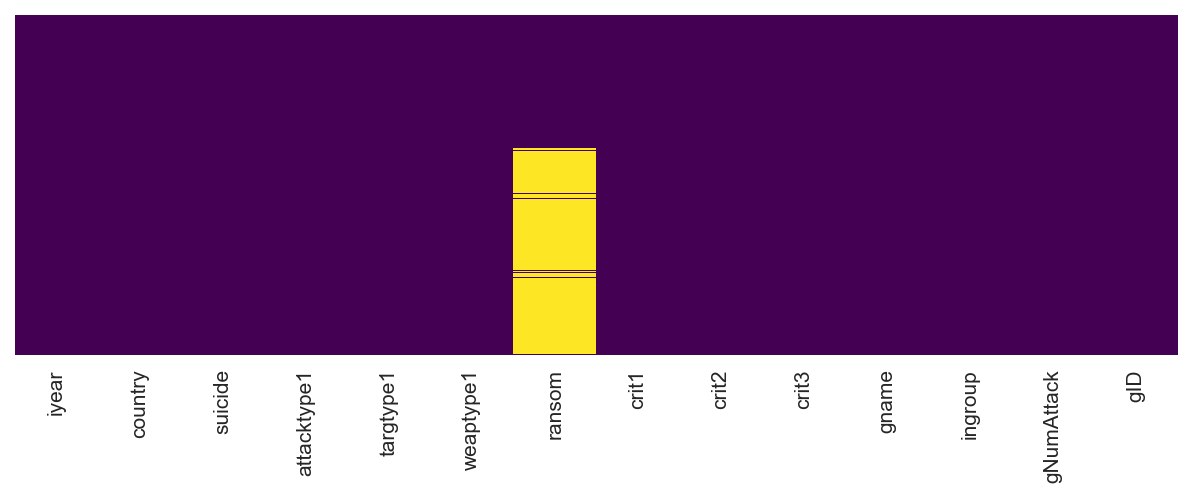

In [7]:
plt.figure(figsize=(10,3),dpi=150)
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

**So we will remove 'ransom' from our features**

In [8]:
data = data.drop('ransom', 1)
features.remove('ransom')
data.head()

,iyear,country,suicide,attacktype1,targtype1,weaptype1,crit1,crit2,crit3,gname,ingroup,gNumAttack,gID
2,1970,160,0,1,10,13,1,1,1,Unknown,-9,71922,0
3,1970,78,0,3,7,6,1,1,1,Unknown,-9,71922,0
4,1970,101,0,7,7,8,1,1,1,Unknown,-9,71922,0
7,1970,217,0,3,21,6,1,1,1,Unknown,-9,71922,0
12,1970,98,0,4,6,5,1,1,1,Unknown,-9,71922,0


### Plot the selected features with respect to the terror groups
This is to make sure that our classification model can be well trained with the selected features

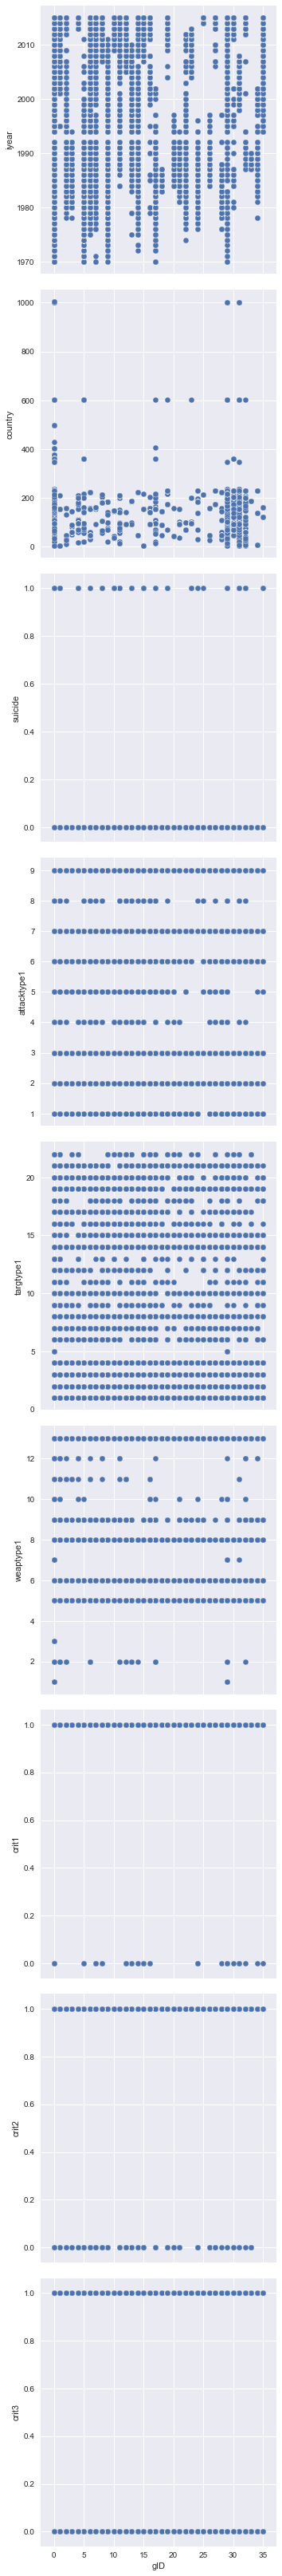

In [9]:
plt.figure(dpi=150)
sns.pairplot(data=data, y_vars=features, x_vars='gID',size=5)

## Feature Scaling

In [10]:
from sklearn import preprocessing

In [11]:
data.describe()

,iyear,country,suicide,attacktype1,targtype1,weaptype1,crit1,crit2,crit3,ingroup,gNumAttack,gID
count,122125.000000,122125.000000,122125.000000,122125.000000,122125.000000,122125.000000,122125.000000,122125.000000,122125.000000,122125.000000,122125.000000,122125.000000
mean,2001.824721,130.003193,0.032729,3.116962,8.299930,6.328868,0.986596,0.995415,0.878018,3061.778899,43352.767910,4.413265
std,12.541312,108.637798,0.177927,1.782174,6.670869,2.029689,0.114999,0.067561,0.327266,8743.937946,34209.886799,7.823165
min,1970.000000,4.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-9.000000,402.000000,0.000000
25%,1990.000000,69.000000,0.000000,2.000000,3.000000,5.000000,1.000000,1.000000,1.000000,-9.000000,2474.000000,0.000000
50%,2008.000000,97.000000,0.000000,3.000000,4.000000,6.000000,1.000000,1.000000,1.000000,-9.000000,71922.000000,0.000000
75%,2013.000000,160.000000,0.000000,3.000000,14.000000,6.000000,1.000000,1.000000,1.000000,520.000000,71922.000000,6.000000
max,2015.000000,1004.000000,1.000000,9.000000,22.000000,13.000000,1.000000,1.000000,1.000000,40269.000000,71922.000000,35.000000


In [12]:
data[features] = preprocessing.scale(data[features])

In [13]:
data.describe()

,iyear,country,suicide,attacktype1,targtype1,weaptype1,crit1,crit2,crit3,ingroup,gNumAttack,gID
count,1.221250e+05,1.221250e+05,1.221250e+05,1.221250e+05,1.221250e+05,1.221250e+05,1.221250e+05,1.221250e+05,1.221250e+05,122125.000000,122125.000000,122125.000000
mean,3.318425e-13,-5.721616e-14,-1.247572e-13,-3.397324e-14,3.722849e-15,3.656677e-14,3.031952e-14,-1.368202e-14,-2.404245e-14,3061.778899,43352.767910,4.413265
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,8743.937946,34209.886799,7.823165
min,-2.537601e+00,-1.159851e+00,-1.839461e-01,-1.187859e+00,-1.094304e+00,-2.625471e+00,-8.579215e+00,-1.473365e+01,-2.682901e+00,-9.000000,402.000000,0.000000
25%,-9.428654e-01,-5.615306e-01,-1.839461e-01,-6.267440e-01,-7.944920e-01,-6.547177e-01,1.165608e-01,6.787186e-02,3.727308e-01,-9.000000,2474.000000,0.000000
50%,4.923970e-01,-3.037923e-01,-1.839461e-01,-6.562918e-02,-6.445858e-01,-1.620294e-01,1.165608e-01,6.787186e-02,3.727308e-01,-9.000000,71922.000000,0.000000
75%,8.910811e-01,2.761187e-01,-1.839461e-01,-6.562918e-02,8.544753e-01,-1.620294e-01,1.165608e-01,6.787186e-02,3.727308e-01,520.000000,71922.000000,6.000000
max,1.050555e+00,8.045086e+00,5.436374e+00,3.301060e+00,2.053724e+00,3.286789e+00,1.165608e-01,6.787186e-02,3.727308e-01,40269.000000,71922.000000,35.000000


## Split our data set into two
### One data set with unkonwn attackers information. And another with no unknown attackers

In [15]:
dataUnknownGroup = data[data['gname'] == 'Unknown']
dataKnownGroup   = data[data['gname'] != 'Unknown']

print('Before splitting, the data has %d rows'% data.shape[0])
print('Unkown attaker group has %d rows (%5.2f%% of total rows)'% (dataUnknownGroup.shape[0], dataUnknownGroup.shape[0]/data.shape[0]*100))
print('After removing unkown attackers we have %d rows (%5.2f%% of total rows)\n'% (dataKnownGroup.shape[0], dataKnownGroup.shape[0]/data.shape[0]*100))

Before splitting, the data has 122125 rows
Unkown attaker group has 71922 rows (58.89% of total rows)
After removing unkown attackers we have 50203 rows (41.11% of total rows)



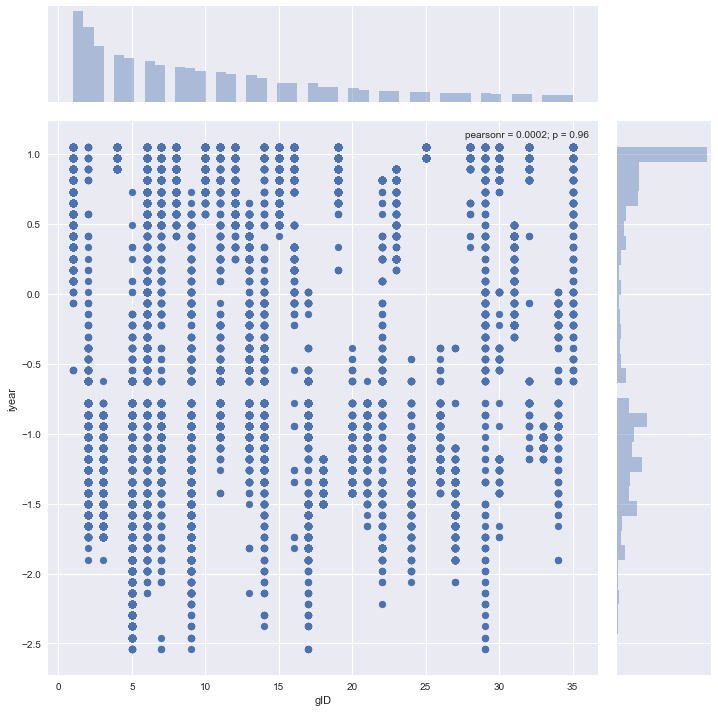

In [315]:
sns.jointplot(data=dataKnownGroup, y='iyear', x='gID',size=10)

## Logistic Regression model
### Split the data set to Train and CV (cross validation)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_cv, y_train, y_cv = train_test_split(dataKnownGroup[features], 
                                                dataKnownGroup['gname'], test_size=0.30, 
                                                random_state=101)

### Training and Predicting

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
predictions = logmodel.predict(X_cv)

### Evaluation
We can check precision,recall,f1-score using classification report!

In [21]:
from sklearn.metrics import classification_report,confusion_matrix

In [22]:
print(classification_report(y_cv,predictions))

                                                             precision    recall  f1-score   support

                                     Abu Sayyaf Group (ASG)       0.00      0.00      0.00       117
                   African National Congress (South Africa)       0.00      0.00      0.00       168
                                           Al-Qaida in Iraq       0.83      0.03      0.05       183
                   Al-Qaida in the Arabian Peninsula (AQAP)       0.77      0.09      0.17       255
                                                 Al-Shabaab       0.24      0.60      0.35       635
                        Basque Fatherland and Freedom (ETA)       0.00      0.00      0.00       595
                                                 Boko Haram       0.17      0.25      0.20       564
             Communist Party of India - Maoist (CPI-Maoist)       0.48      0.78      0.60       498
                  Corsican National Liberation Front (FLNC)       0.00      0.00      0.00

/Users/aminMac/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**So clearly linear logistic regression is not a good way to represent the data**

**Now we try Random Forest**

## Random Forests

In [23]:
from sklearn.ensemble import RandomForestClassifier

### Fit the model for a range of number of trees

In [24]:
estimatorList = range(2, 101, 4)
pred_f1 = []

for (i, n_est) in enumerate(estimatorList):
    # Train the model
    rfc = RandomForestClassifier(n_estimators=n_est)
    rfc.fit(X_train, y_train)
    
    # make predictions
    rfc_pred = rfc.predict(X_cv)
    pred_report=classification_report(y_cv, rfc_pred, digits=6).split()
    pred_f1.append(float(pred_report[-2]))
    
    # Progress Report
    print('Progress: %2i/%2i ,  n_estimators = %3i ,  Average f1 = %6.4f'%(i+1, len(estimatorList), n_est, pred_f1[-1]))

Progress:  1/25 ,  n_estimators =   2 ,  Average f1 = 0.8816
Progress:  2/25 ,  n_estimators =   6 ,  Average f1 = 0.8960
Progress:  3/25 ,  n_estimators =  10 ,  Average f1 = 0.9061
Progress:  4/25 ,  n_estimators =  14 ,  Average f1 = 0.9025
Progress:  5/25 ,  n_estimators =  18 ,  Average f1 = 0.9064
Progress:  6/25 ,  n_estimators =  22 ,  Average f1 = 0.9061
Progress:  7/25 ,  n_estimators =  26 ,  Average f1 = 0.9085
Progress:  8/25 ,  n_estimators =  30 ,  Average f1 = 0.9083
Progress:  9/25 ,  n_estimators =  34 ,  Average f1 = 0.9109
Progress: 10/25 ,  n_estimators =  38 ,  Average f1 = 0.9076
Progress: 11/25 ,  n_estimators =  42 ,  Average f1 = 0.9100
Progress: 12/25 ,  n_estimators =  46 ,  Average f1 = 0.9109
Progress: 13/25 ,  n_estimators =  50 ,  Average f1 = 0.9098
Progress: 14/25 ,  n_estimators =  54 ,  Average f1 = 0.9081
Progress: 15/25 ,  n_estimators =  58 ,  Average f1 = 0.9095
Progress: 16/25 ,  n_estimators =  62 ,  Average f1 = 0.9085
Progress: 17/25 ,  n_est

### Print f1 score with respect to the number of trees and determine the optimum value

In [25]:
n_est_best_arg = np.argmax(pred_f1)
n_est_best = estimatorList[n_est_best_arg]
print('We get the best f1 score whith {} trees.'.format(n_est_best))

We get the best f1 score whith 90 trees.


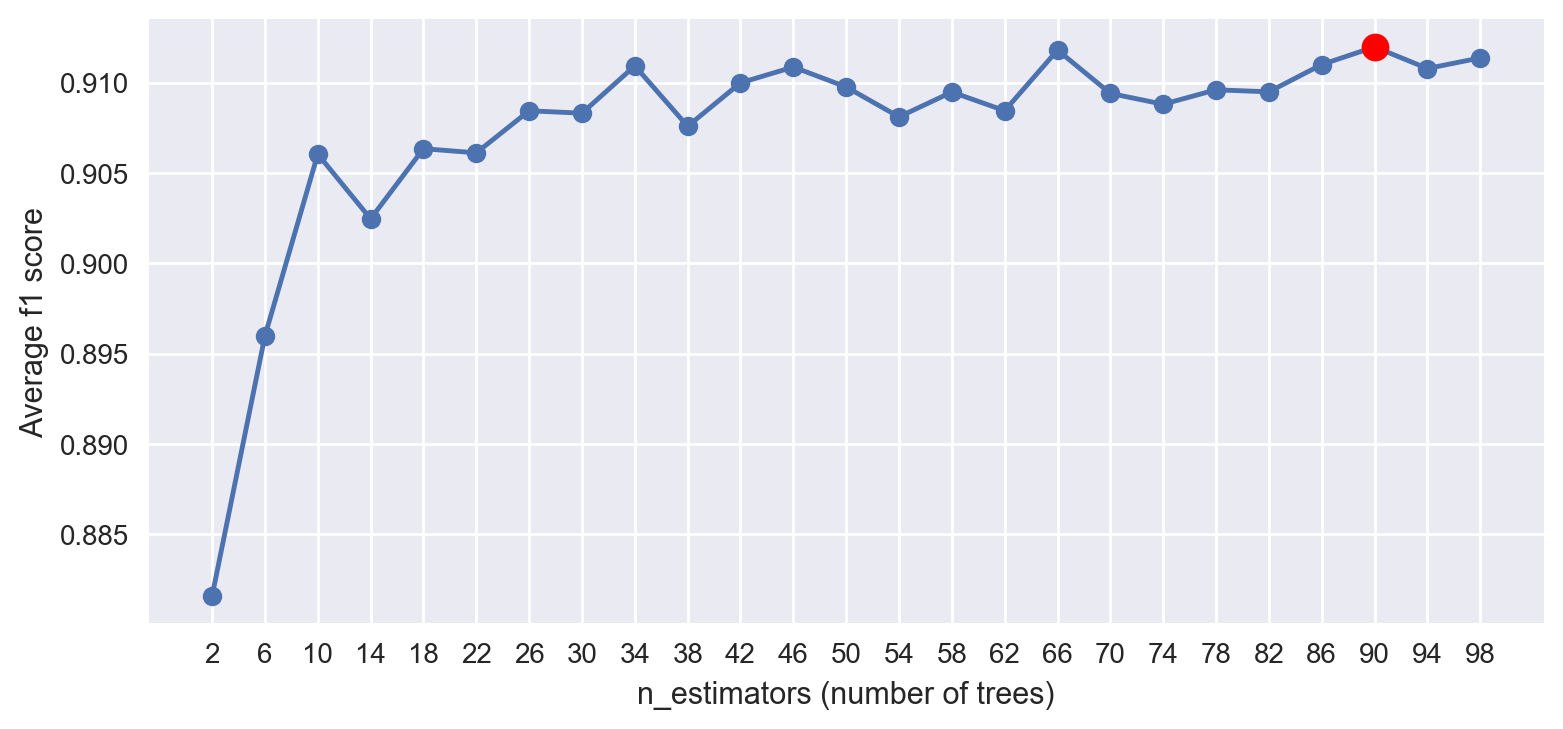

In [26]:
plt.figure(figsize=(9,4),dpi=200)
plt.plot(estimatorList, pred_f1, '-o')
plt.plot(n_est_best, pred_f1[n_est_best_arg],'or',markersize=10)
plt.xticks(estimatorList)
plt.xlabel('n_estimators (number of trees)')
plt.ylabel('Average f1 score')

### Train the model again with the optimum number of trees and print the full classification report

In [27]:
# Train the model
rfc = RandomForestClassifier(n_estimators=n_est_best)
rfc.fit(X_train, y_train)

# make predictions
rfc_pred = rfc.predict(X_cv)

In [28]:
print(classification_report(y_cv,rfc_pred, digits=3))

                                                             precision    recall  f1-score   support

                                     Abu Sayyaf Group (ASG)      0.660     0.598     0.628       117
                   African National Congress (South Africa)      1.000     0.994     0.997       168
                                           Al-Qaida in Iraq      0.872     0.852     0.862       183
                   Al-Qaida in the Arabian Peninsula (AQAP)      0.825     0.886     0.854       255
                                                 Al-Shabaab      0.977     0.987     0.982       635
                        Basque Fatherland and Freedom (ETA)      0.978     0.990     0.984       595
                                                 Boko Haram      0.984     0.995     0.989       564
             Communist Party of India - Maoist (CPI-Maoist)      0.939     0.898     0.918       498
                  Corsican National Liberation Front (FLNC)      0.954     0.949     0.951